<a href="https://colab.research.google.com/github/shubhamByte/Machine-Learning/blob/main/PGD_and_Mask_Based_attack_in_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [132]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

# Preparing the Dataset

In [133]:
# Transformer
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Downloading Data
train_data = datasets.SVHN(root='./data', split = 'train', download=True, transform=transform)
test_data = datasets.SVHN(root='./data', split = 'test', download=True, transform=transform)


trainloader = torch.utils.data.DataLoader(train_data, batch_size= 512, shuffle=True, num_workers = 2)
testloader = torch.utils.data.DataLoader(test_data, batch_size= 512, shuffle=False, num_workers = 2)

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


In [134]:
len(train_data), len(test_data), train_data[8][0].shape

(73257, 26032, torch.Size([3, 32, 32]))

### Visualise the sample data

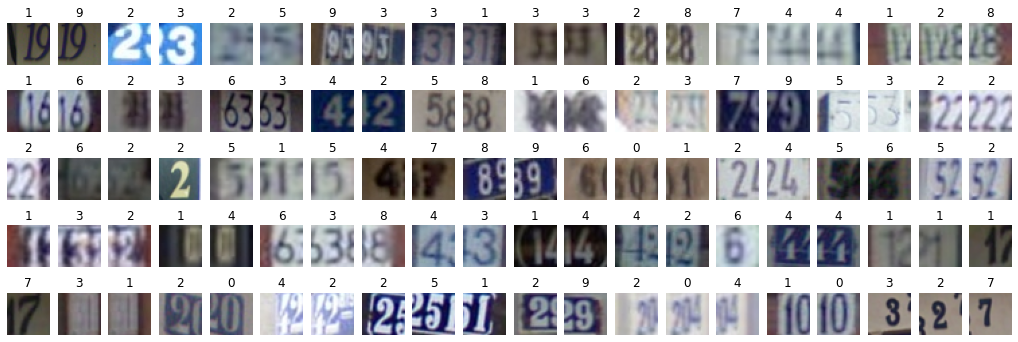

In [135]:
figure = plt.figure(figsize=(18, 6))
cols, rows = 20, 5


for i in range(cols * rows):
  img, label = train_data[i]
  figure.add_subplot(rows, cols, i + 1)     # starts from 1 that's why added 1

  plt.imshow((img.numpy().transpose(1,2,0)) * 0.5 + 0.5)
 
  plt.title(label)
  plt.axis("off")

plt.show()


# CNN Model

### Hyperparameters

In [136]:
input_width = 32
input_height = 32
input_channels = 3
input_pixels = input_width * input_height * input_channels

n_conv1 = 32
n_conv2 = 64
n_conv3 = 128
n_conv4 = 64
n_conv5 = 64

kernelConv = 4
stride_conv = 1
kernelPool = 3

input_size_to_hidden = 1600       # 5 * 5 * 64
n_FC1 = 512

n_classes = 10

learning_rate = 0.001
num_epochs = 3


### CNN MODEL

In [137]:
# CNN architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # first convolution layer
        self.conv1 = nn.Conv2d(in_channels=input_channels, out_channels=n_conv1, kernel_size=kernelConv)
        nn.init.kaiming_uniform_(self.conv1.weight, nonlinearity='relu')        # he intialisation
        self.act1 = nn.ReLU()                                                   

        # second convolution layer
        self.conv2 = nn.Conv2d(in_channels=n_conv1, out_channels=n_conv2, kernel_size=kernelConv)
        nn.init.kaiming_uniform_(self.conv2.weight, nonlinearity='relu')        # he intialisation
        self.act2 = nn.ReLU()                                                   

        # third convolution layer
        self.conv3 = nn.Conv2d(in_channels=n_conv2, out_channels=n_conv3, kernel_size=kernelConv)
        nn.init.kaiming_uniform_(self.conv3.weight, nonlinearity='relu')        # he intialisation
        self.act3 = nn.ReLU() 
                                                          
        # fourth convolution layer
        self.conv4 = nn.Conv2d(in_channels=n_conv3, out_channels=n_conv4, kernel_size=kernelConv)
        nn.init.kaiming_uniform_(self.conv4.weight, nonlinearity='relu')        # he intialisation
        self.act4 = nn.ReLU()   
                                                        
        # third convolution layer
        self.conv5 = nn.Conv2d(in_channels=n_conv4, out_channels=n_conv5, kernel_size=kernelConv)
        nn.init.kaiming_uniform_(self.conv5.weight, nonlinearity='relu')        # he intialisation
        self.act5 = nn.ReLU()                                                   
        # pooling
        self.pool1 = nn.MaxPool2d(kernel_size = kernelPool, stride = kernelPool)
        

        # fully connected layer
        self.FC1 = nn.Linear(input_size_to_hidden, n_FC1)
        nn.init.kaiming_uniform_(self.FC1.weight, nonlinearity='relu')
        self.act6 = nn.ReLU()


        # output layer
        self.FC2 = nn.Linear(n_FC1, n_classes)
        nn.init.xavier_uniform_(self.FC2.weight)
        self.act7 = nn.LogSoftmax(dim=1)


        

    # forward overloading
    def forward(self, X):
        # input to first hidden layer
        X = self.conv1(X)
        X = self.act1(X)

        # second hidden layer
        X = self.conv2(X)
        X = self.act2(X)
 
        # third hidden layer
        X = self.conv3(X)
        X = self.act3(X)
        
        # fourth hidden layer
        X = self.conv4(X)
        X = self.act4(X)
        
        # fifth hidden layer
        X = self.conv5(X)
        X = self.act5(X)
        
        X = self.pool1(X)

        # flatten
        X = X.reshape(-1, 64*5*5)
        
        # first fc layer
        X = self.FC1(X)
        X = self.act6(X)

        # output layer
        X = self.FC2(X)
        X = self.act7(X)
        return X


# Training the model

In [138]:
model = CNN()
optimizer = optim.Adam(model.parameters(), lr = learning_rate) 
criterion = nn.CrossEntropyLoss()

loss_list = []

for epoch in range(num_epochs):
    running_loss = 0.0
    # enumerate mini batches
    # i is batch_indx
    for i, (inputs, targets) in enumerate(trainloader):
        # clear the gradients
        optimizer.zero_grad()
        # compute the model output
        yhat = model(inputs)
        # calculate loss
        loss = criterion(yhat, targets)
        # credit assignment
        loss.backward()
        # update model weights
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 40 == 39:    # print every 40 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 40:.3f}')
            loss_list.append(running_loss / 40)
            running_loss = 0.0



print('Finished Training.')

[1,    40] loss: 2.179
[1,    80] loss: 1.109
[1,   120] loss: 0.680
[2,    40] loss: 0.499
[2,    80] loss: 0.459
[2,   120] loss: 0.425
[3,    40] loss: 0.381
[3,    80] loss: 0.353
[3,   120] loss: 0.348
Finished Training.


### Iterations and epochs vs Loss

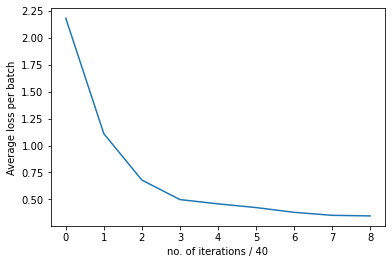

In [139]:
x_values = range(len(loss_list)) 
plt.plot(x_values,loss_list)
plt.xlabel('no. of iterations / 40')
plt.ylabel('Average loss per batch')
plt.show()

# Predictions and Accuracy

In [140]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 26032 test images: {100 * correct // total} %')

Accuracy of the network on the 26032 test images: 87 %


# MLP model

### Parameters

In [141]:
input_width = 32
input_height = 32
input_channels = 3
input_pixels = input_width * input_height * input_channels

n_fc1 = 256
n_fc2 = 512
n_fc3 = 1024
n_fc4 = 512
n_fc5 = 256

n_classes = 10

learning_rate = 0.001
num_epochs = 4

### MLP MODEL

In [142]:
# model definition
class MLP(nn.Module):
    # define model elements
    def __init__(self):
        super(MLP, self).__init__()

        # fc1 layer
        self.fc1 = nn.Linear(input_pixels, n_fc1)
        nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
        self.act1 = nn.ReLU()

        # fc2 layer
        self.fc2 = nn.Linear(n_fc1, n_fc2)
        nn.init.kaiming_uniform_(self.fc2.weight, nonlinearity='relu')
        self.act2 = nn.ReLU()

        # fc3 layer
        self.fc3 = nn.Linear(n_fc2, n_fc3)
        nn.init.kaiming_uniform_(self.fc3.weight, nonlinearity='relu')
        self.act3 = nn.ReLU()

        # fc4 layer
        self.fc4 = nn.Linear(n_fc3, n_fc4)
        nn.init.kaiming_uniform_(self.fc4.weight, nonlinearity='relu')
        self.act4 = nn.ReLU()

        # fc5 layer
        self.fc5 = nn.Linear(n_fc4, n_fc5)
        nn.init.kaiming_uniform_(self.fc5.weight, nonlinearity='relu')
        self.act5 = nn.ReLU()

        # output layer
        self.fc6 = nn.Linear(n_fc5, n_classes)
        nn.init.xavier_uniform_(self.fc6.weight)
        self.act6 = nn.LogSoftmax(dim=1)
 
    # forward propagate input
    def forward(self, X):

        X = X.reshape(-1, input_pixels)

        X = self.fc1(X)
        X = self.act1(X)

        X = self.fc2(X)
        X = self.act2(X)

        X = self.fc3(X)
        X = self.act3(X)

        X = self.fc4(X)
        X = self.act4(X)

        X = self.fc5(X)
        X = self.act5(X)

        X = self.fc6(X)
        X = self.act6(X)

        return X



# TRAINING MLP MODEL

In [143]:
model_mlp = MLP()
optimizer = optim.Adam(model_mlp.parameters(), lr = learning_rate) 
criterion = nn.CrossEntropyLoss()

loss_list = []

for epoch in range(num_epochs):
    running_loss = 0.0
    # enumerate mini batches
    # i is batch_indx
    for i, (inputs, targets) in enumerate(trainloader):
        # clear the gradients
        optimizer.zero_grad()
        # compute the model_2 output
        yhat = model_mlp(inputs)
        # calculate loss
        loss = criterion(yhat, targets)
        # credit assignment
        loss.backward()
        # update model_2 weights
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 40 == 39:    # print every 40 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 40:.3f}')
            loss_list.append(running_loss / 40)
            running_loss = 0.0



print('Finished Training.')

[1,    40] loss: 2.281
[1,    80] loss: 1.538
[1,   120] loss: 1.164
[2,    40] loss: 0.946
[2,    80] loss: 0.870
[2,   120] loss: 0.824
[3,    40] loss: 0.764
[3,    80] loss: 0.723
[3,   120] loss: 0.720
[4,    40] loss: 0.643
[4,    80] loss: 0.628
[4,   120] loss: 0.611
Finished Training.


### Iterations and epochs vs Loss

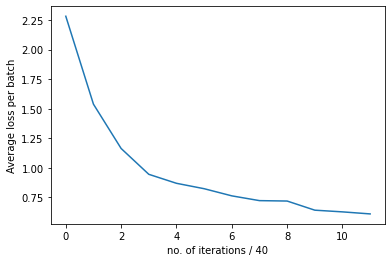

In [144]:
x_values = range(len(loss_list)) 
plt.plot(x_values,loss_list)
plt.xlabel('no. of iterations / 40')
plt.ylabel('Average loss per batch')
plt.show()

## ACCURACY

In [145]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model_mlp(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 26032 test images: {100 * correct // total} %')

Accuracy of the network on the 26032 test images: 75 %




---



# Adversarial Attacks

## 1. Masked - Based Attack

### MASK FUNCTION

In [146]:

def random_block_mask(image, p):

    c, h, w = image.shape
    mask_h = int(h*p)
    mask_w = int(w*p)
    top = np.random.randint(0, h - mask_h)
    left = np.random.randint(0, w - mask_w)
    bottom = top + mask_h
    right = left + mask_w
    image[:, top:bottom, left:right] = 0.0

    return image


### ACCURACY OF CNN AND MLP MODEL WHEN VARYING P_VALUES

In [147]:
subset_sampler = torch.utils.data.SubsetRandomSampler(range(5000))

# Create the data loader for the subset of data
testloader_attack = torch.utils.data.DataLoader(test_data, batch_size=512, sampler=subset_sampler)



# Define a range of values for p
p_values = [0.0,0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

# Create a list to store the accuracy results
accuracies_cnn = []
accuracies_mlp = []


for p in p_values: 
    correct_cnn = 0
    correct_mlp = 0
    total = 0
    for data in testloader_attack:

        images, labels = data

        masked_images = images.clone()

        for i in range(len(masked_images)):
            masked_images[i] = random_block_mask(masked_images[i], p)
            


        # for cnn
        outputs = model(masked_images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct_cnn += (predicted == labels).sum().item()

        # for mlp
        outputs2 = model_mlp(masked_images)
        _, predicted2 = torch.max(outputs2.data, 1)

        correct_mlp += (predicted2 == labels).sum().item()
      
    cnn_acc = 100 * correct_cnn / total
    accuracies_cnn.append(cnn_acc)

    mlp_acc = 100 * correct_mlp / total
    accuracies_mlp.append(mlp_acc)
  
    # Calculate final accuracy for this epsilon
    print("p value: {}\tTest Accuracy cnn = {} / {} = {} %\tTest Accuracy mlp = {} / {} = {} %".format(p, correct_cnn, total, cnn_acc, correct_mlp, total, mlp_acc))


p value: 0.0	Test Accuracy cnn = 4374 / 5000 = 87.48 %	Test Accuracy mlp = 3799 / 5000 = 75.98 %
p value: 0.1	Test Accuracy cnn = 4282 / 5000 = 85.64 %	Test Accuracy mlp = 3757 / 5000 = 75.14 %
p value: 0.2	Test Accuracy cnn = 4000 / 5000 = 80.0 %	Test Accuracy mlp = 3525 / 5000 = 70.5 %
p value: 0.3	Test Accuracy cnn = 3640 / 5000 = 72.8 %	Test Accuracy mlp = 3070 / 5000 = 61.4 %
p value: 0.4	Test Accuracy cnn = 3067 / 5000 = 61.34 %	Test Accuracy mlp = 2535 / 5000 = 50.7 %
p value: 0.5	Test Accuracy cnn = 1871 / 5000 = 37.42 %	Test Accuracy mlp = 1655 / 5000 = 33.1 %
p value: 0.6	Test Accuracy cnn = 997 / 5000 = 19.94 %	Test Accuracy mlp = 1074 / 5000 = 21.48 %
p value: 0.7	Test Accuracy cnn = 584 / 5000 = 11.68 %	Test Accuracy mlp = 631 / 5000 = 12.62 %
p value: 0.8	Test Accuracy cnn = 619 / 5000 = 12.38 %	Test Accuracy mlp = 578 / 5000 = 11.56 %


### COMPARING MLP VS CNN ACCURACIES AFTER ATTACK

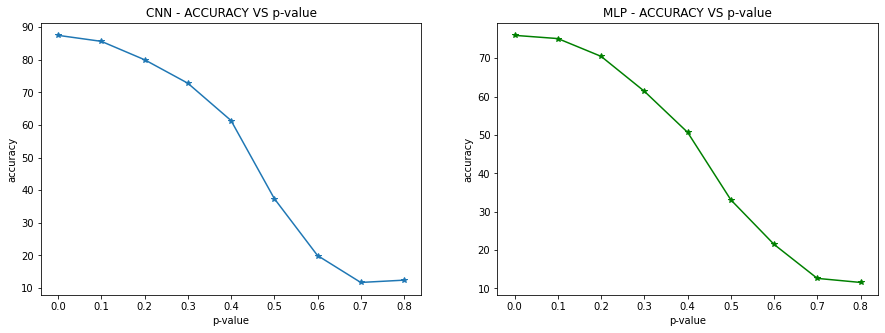

In [148]:
# Create a figure object with three subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Plot the data for each subplot
axes[0].plot(p_values, accuracies_cnn, '*-')
axes[0].set_xlabel('p-value')
axes[0].set_ylabel('accuracy')
axes[0].set_title('CNN - ACCURACY VS p-value')

axes[1].plot(p_values, accuracies_mlp, '*-', c='g')
axes[1].set_xlabel('p-value')
axes[1].set_ylabel('accuracy')
axes[1].set_title('MLP - ACCURACY VS p-value')


# Show the figure
plt.show()

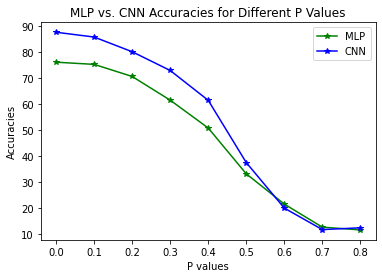

In [149]:

plt.plot(p_values, accuracies_mlp, '*-', c='g', label='MLP')
plt.plot(p_values, accuracies_cnn, '*-', c='b', label='CNN')

plt.xlabel('P values')
plt.ylabel('Accuracies')
plt.title('MLP vs. CNN Accuracies for Different P Values')
plt.legend()

plt.show()


## 2. PGD ATTACK

In [150]:
def pgd_attack(model, images, labels, eps=0.1, alpha=0.01, num_iters=10):

    adv_images = images.clone().detach().requires_grad_(True)
    for i in range(num_iters):
        outputs = model(adv_images)
        loss = criterion(outputs, labels)
        loss.backward()
        adv_images_grad = adv_images.grad.detach()
        adv_images_grad_sign = adv_images_grad.sign()
        adv_images = adv_images + alpha * adv_images_grad_sign
        adv_images = torch.min(torch.max(adv_images, images - eps), images + eps)
        adv_images = torch.clamp(adv_images, 0, 1)
        adv_images.detach_()
        adv_images.requires_grad_()
    return adv_images

### ATTACKING CNN AND MLP MODEL WITH PGD (FOR DIFFERENT MAX ITERATIONS)

In [151]:
total_sample = 100
subset_sampler = torch.utils.data.SubsetRandomSampler(range(total_sample))
testloader_attack = torch.utils.data.DataLoader(test_data, batch_size=128, sampler=subset_sampler)

iteration_values = [0, 1, 2, 3, 4]
alpha = 0.01
eps = 0.1


# Create a list to store the accuracy results
accuracies_cnn = []
accuracies_mlp = []

for num_iters in iteration_values: 
    correct_cnn = 0
    correct_mlp = 0
    total = 0

    for data in testloader_attack:

        images, labels = data

        
        pgd_images_cnn = pgd_attack(model, images, labels, eps, alpha, num_iters)



        # for cnn
        outputs = model(pgd_images_cnn)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct_cnn += (predicted == labels).sum().item()

        # for mlp
        pgd_images_mlp = pgd_attack(model_mlp, images, labels, eps, alpha, num_iters)
        outputs2 = model_mlp(pgd_images_mlp)
        _, predicted2 = torch.max(outputs2.data, 1)

        correct_mlp += (predicted2 == labels).sum().item()

      
    cnn_acc = 100 * correct_cnn / total
    accuracies_cnn.append(cnn_acc)

    mlp_acc = 100 * correct_mlp / total
    accuracies_mlp.append(mlp_acc)

    print("iteration : {}\tTest Accuracy cnn = {} / {} = {} %\tTest Accuracy mlp = {} / {} = {} %".format(num_iters, correct_cnn, total, cnn_acc, correct_mlp, total, mlp_acc))


iteration : 0	Test Accuracy cnn = 88 / 100 = 88.0 %	Test Accuracy mlp = 75 / 100 = 75.0 %
iteration : 1	Test Accuracy cnn = 55 / 100 = 55.0 %	Test Accuracy mlp = 47 / 100 = 47.0 %
iteration : 2	Test Accuracy cnn = 37 / 100 = 37.0 %	Test Accuracy mlp = 34 / 100 = 34.0 %
iteration : 3	Test Accuracy cnn = 24 / 100 = 24.0 %	Test Accuracy mlp = 21 / 100 = 21.0 %
iteration : 4	Test Accuracy cnn = 19 / 100 = 19.0 %	Test Accuracy mlp = 17 / 100 = 17.0 %


### VISUALISING CNN AND MLP ACCURACIES AFTER ATTACK

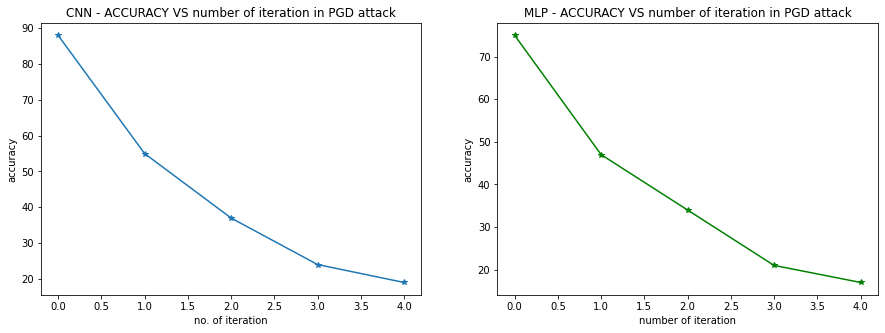

In [152]:
# Create a figure object with three subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Plot the data for each subplot
axes[0].plot(iteration_values, accuracies_cnn, '*-')
axes[0].set_xlabel('no. of iteration')
axes[0].set_ylabel('accuracy')
axes[0].set_title('CNN - ACCURACY VS number of iteration in PGD attack')

axes[1].plot(iteration_values, accuracies_mlp, '*-', c='g')
axes[1].set_xlabel('number of iteration')
axes[1].set_ylabel('accuracy')
axes[1].set_title('MLP - ACCURACY VS number of iteration in PGD attack')


# Show the figure
plt.show()

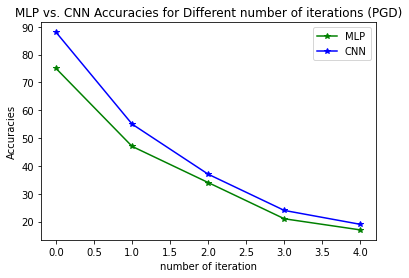

In [153]:
plt.plot(iteration_values, accuracies_mlp, '*-', c='g', label='MLP')
plt.plot(iteration_values, accuracies_cnn, '*-', c='b', label='CNN')

plt.xlabel('number of iteration')
plt.ylabel('Accuracies')
plt.title('MLP vs. CNN Accuracies for Different number of iterations (PGD)')
plt.legend()

plt.show()



---

THE END



---

